In [2]:
import itertools

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow.keras.backend as K
from tensorflow.python.keras.regularizers import l2
from tensorflow.python.keras.initializers import (Zeros, glorot_normal, glorot_uniform)

In [3]:
from collections import namedtuple

DEFAULT_GROUP_NAME = "default_group"


# 统一输入
# SparseFeat继承了namedtuple, 通过__new__方法中设置的参数，实现对namedtuple中某些字段的初始化
class SparseFeat(namedtuple('SparseFeat',
                            ['name', 'vocabulary_size', 'embedding_dim', 'use_hash', 'dtype', 'embedding_name',
                             'group_name'])):
    # 它的作用是阻止在实例化类时为实例分配dict，默认情况下每个类都会有一个dict, 通过__dict__访问，这个dict维护了这个实例的所有属性
    # 当需要创建大量的实例时，创建大量的__dict__会浪费大量的内存，所以这里使用__slots__()进行限制，当然如果需要某些属性被访问到，需要
    # 在__slots__()中将对应的属性填写进去
    __slots__ = ()

    # new方法是在__init__方法之前运行的，new方法的返回值是类的实例，也就是类中的self
    # new方法中传入的参数是cls,而init的方法传入的参数是self
    # __new__ 负责对象的创建，__init__ 负责对象的初始化
    # 这里使用__new__的原因是，这里最终是想创建一个namedtuple对象，并且避免namedtuple初始化时需要填写所有参数的的情况，使用了一个类来包装
    def __new__(cls, name, vocabulary_size, embedding_dim=4, use_hash=False, dtype="int32", embedding_name=None,
                group_name=DEFAULT_GROUP_NAME):
        if embedding_name is None:
            embedding_name = name
        if embedding_dim == "auto":
            embedding_dim = 6 * int(pow(vocabulary_size, 0.25))  # 如果没有指定embedding_dim的一个默认值，这个默认值是怎么来的？
        return super(SparseFeat, cls).__new__(cls, name, vocabulary_size, embedding_dim, use_hash, dtype,
                                              embedding_name, group_name)

    # 要想使用自定义的类作为字典的键，就需要重写类的哈希函数，否则无法将其作为字典的键来使用
    # 由于这个类不需要比较大小所以不必重写__eq__()方法
    def __hash__(self):
        return self.name.__hash__()


# 数值特征，这里需要注意，数值特征不一定只是一维的，也可以是一个多维的
class DenseFeat(namedtuple('DenseFeat', ['name', 'dimension', 'dtype'])):
    __slots__ = ()

    def __new__(cls, name, dimension=1, dtype="float32"):
        return super(DenseFeat, cls).__new__(cls, name, dimension, dtype)

    def __hash__(self):
        return self.name.__hash__()


# 长度变化的稀疏特征，其实就是id序列特征
class VarLenSparseFeat(namedtuple('VarLenSparseFeat',
                                  ['sparsefeat', 'maxlen', 'combiner', 'length_name', 'weight_name', 'weight_norm'])):
    __slots__ = ()

    def __new__(cls, sparsefeat, maxlen, combiner="mean", length_name=None, weight_name=None, weight_norm=True):
        return super(VarLenSparseFeat, cls).__new__(cls, sparsefeat, maxlen, combiner, length_name, weight_name,
                                                    weight_norm)

    # 由于这里传进来的sparsefeat, 本身就是一个自定义的类型，也有很多有用的信息，例如name, embedding_dim等等
    # 对于VarLenSparseFeat类来说，只不过是一个sparsefeat的序列，需要获取到sparsefeat的相关属性

    # 使用@property装饰器，将一个函数的返回值作为类的属性来使用
    @property
    def name(self):
        return self.sparsefeat.name

    @property
    def vocabulary_size(self):
        return self.sparsefeat.vocabulary_size

    @property
    def embedding_dim(self):
        return self.sparsefeat.embedding_dim

    @property
    def use_hash(self):
        return self.sparsefeat.use_hash

    @property
    def dtype(self):
        return self.sparsefeat.dtype

    @property
    def embedding_name(self):
        return self.sparsefeat.embedding_name

    @property
    def group_name(self):
        return self.sparsefeat.group_name

    def __hash__(self):
        return self.name.__hash__()

In [18]:
#构建输入层
#将输入的数据转换成字典的形式，定义输入层的时候让输入层的name和字典中特征的key一致，就可以使得输入的数据和对应的Input层对应
def build_input_layers(feature_columns):
    """构建Input层字典，并以dense和sparse两类字典的形式返回"""
    dense_input_dict, sparse_input_dict = {}, {}
    for fc in feature_columns:
        if isinstance(fc, SparseFeat):
            sparse_input_dict[fc.name] = Input(shape=(1,), name=fc.name, dtype=fc.dtype)
        elif isinstance(fc, DenseFeat):
            dense_input_dict[fc.name] = Input(shape=(fc.dimension,), name=fc.name, dtype=fc.dtype)
    return dense_input_dict, sparse_input_dict

In [5]:
#构建embedding层
def build_embedding_layers(feature_columns, input_layer_dict, is_linear):
    #定义一个embedding层对应的字典
    embedding_layers_dict = dict()
    
    
    #将特征中的sparse特征筛选出来
    sparse_features_columns = list(filter(lambda x:isinstance(x, SparseFeat), feature_columns)) if feature_columns else []
    
    #如果是用于线性部分的embedding层，其维度是1，否则维度是自己定义的embedding维度
    if is_linear:
        for fc in sparse_features_columns:
            embedding_layers_dict[fc.name] = Embedding(fc.vocabulary_size, 1, name='1d_emb_'+fc.name)
    else:
        for fc in sparse_features_columns:
            embedding_layers_dict[fc.name] = Embedding(fc.vocabulary_size, fc.embedding_dim, name='kd_emd_'+fc.name)
    return embedding_layers_dict

#将所有的sparse特征embedding拼接
def concat_embedding_list(feature_columns, input_layer_dict, embedding_layer_dict, flatten=False):
    #将sparse特征筛选出来
    sparse_feature_columns = list(filter(lambda x:isinstance(x, SparseFeat), feature_columns))
    
    embedding_list = []
    for fc in sparse_feature_columns:
        _input = input_layer_dict[fc.name] #获取输入层
        _embed = embedding_layer_dict[fc.name] #B*1*dim 获取对应的embedding层
        embed = _embed(_input) #B*dim 将input层输入到embedding层中
        
        #是否需要flatten, 如果embedding列表最终是直接输入到Dense层中，需要进行Flatten，否则不需要
        if flatten:
            embed = Flatten()(embed)
        embedding_list.append(embed)
    return embedding_list

In [6]:
def get_dnn_output(dnn_input, hidden_units=[1024, 512, 256], dnn_dropout=0.3, activation='relu'):
    #建立dnn_network
    dnn_network = [Dense(units=unit, activation=activation) for unit in hidden_units]
    dropout = Dropout(dnn_dropout)
    
    #前向传播
    x = dnn_input
    for dnn in dnn_network:
        x = dropout(dnn(x))
    return x

In [7]:
#得到线性部分的计算结果，即线性部分计算的前向传播逻辑
def get_linear_logits(dense_input_dict, sparse_input_dict, linear_feature_columns):
    """
    线性部分的计算，所有特征的Input层，然后经过一个全连接层线性计算结果logits
    即FM线性部分的那块计算w1x1+w2x2+...wnxn + b,只不过，连续特征和离散特征这里的线性计算还不太一样
        连续特征由于是数值，可以直接过全连接，得到线性这边的输出。 
        离散特征需要先embedding得到1维embedding，然后直接把这个1维的embedding相加就得到离散这边的线性输出。
    :param dense_input_dict: A dict. 连续特征构建的输入层字典 形式{'dense_name': Input(shape, name, dtype)}
    :param sparse_input_dict: A dict. 离散特征构建的输入层字典 形式{'sparse_name': Input(shape, name, dtype)}
    :param linear_feature_columns: A list. 里面的每个元素是namedtuple(元组的一种扩展类型，同时支持序号和属性名访问组件)类型，表示的是linear数据的特征封装版
    """
    
    #把所有的dense特征合并起来，经过一个神经元的全连接，做的计算，w1*1+w2*2+w3*3+...+wn*n
    concat_dense_inputs = Concatenate(axis=1)(list(dense_input_dict.values()))
    dense_logits_output = Dense(1)(concat_dense_inputs)
    
    # 获取linear部分sparse特征的embedding层，这里使用embedding的原因：
    # 对于linear部分直接将特征进行OneHot然后通过一个全连接层，当维度特别大的时候，计算比较慢
    # 使用embedding层的好处就是可以通过查表的方式获取到非零元素对应的权重，然后将这些权重相加，提升效率
    linear_embedding_layers = build_embedding_layers(linear_feature_columns, sparse_input_dict, is_linear=True)
    
    #将一维的embedding拼接，注意这里需要一个Flatten层，使维度对应
    sparse_1d_embed = []
    for fc in linear_feature_columns:
        #离散特征要进行embedding
        if isinstance(fc, SparseFeat):
            #找到对应Input层，然后后面接上embedding层
            feat_input = sparse_input_dict[fc.name]
            embed = Flatten()(linear_embedding_layers[fc.name](feat_input))
            sparse_1d_embed.append(embed)
    
    #embedding中查询得到的权重就是对应onehot向量中一个位置的权重，所以后面不用再接一个全连接了，本身一维的embedding就相当于全连接
    #只不过这里的输入特征只有0和1，所以直接向非零元素对应的权重相加就等同于进行了全连接操作(非零元素部分乘的是1)
    sparse_logits_output = Add()(sparse_1d_embed)
    
    #最终将dense特征和sparse特征对应的logits相加，得到最终linear的logits
    linear_part = Add()([dense_logits_output, sparse_logits_output])
    return linear_part

In [28]:
class SENETLayer(Layer):
    def __init__(self, reduction_ratio, seed=2021):
        super(SENETLayer, self).__init__()
        self.reduction_ratio = reduction_ratio
        self.seed = seed
    def build(self, input_shape):
        #input_shape [None, field_nums, embedding_dim]
        self.field_size = input_shape[1]
        self.embedding_size = input_shape[-1]
        
        #中间层的神经单元个数 f/r
        reduction_size = max(1, self.field_size // self.reduction_ratio)
        
        #FC layer1和layer2的参数
        self.W_1 = self.add_weight(shape=(self.field_size, reduction_size), initializer=glorot_normal(seed=self.seed), name='W_1')
        self.W_2 = self.add_weight(shape=(reduction_size, self.field_size), initializer=glorot_normal(seed=self.seed), name='W_2')
        
        self.tensordot = tf.keras.layers.Lambda(lambda x:tf.tensordot(x[0],x[1], axes=(-1,0)))
        
        #Be sure to call this somewhere
        super(SENETLayer, self).build(input_shape)
    def call(self, inputs):
        #inputs [None, field_num, embed_dim]
        
        #Squeeze->[None, filed_num]
        Z = tf.reduce_mean(inputs, axis=-1)
        
        #Excitation
        A_1 = tf.nn.relu(self.tensordot([Z, self.W_1])) #[None, reduction_size]
        A_2 = tf.nn.relu(self.tensordot([A_1, self.W_2])) #[None, field_num]
        
        #Re-Weight
        V = tf.multiply(inputs, tf.expand_dims(A_2, axis=2)) #[None, field_num, embedding_dim]
        return V

In [9]:
class BilinearInteraction(Layer):
    """BilinearInteraction Layer used in FiBiNET.
      Input shape
        - 3D tensor with shape: ``(batch_size,field_size,embedding_size)``.
      Output shape
        - 3D tensor with shape: ``(batch_size,filed_size*(filed_size-1)/2,embedding_size)``.
    """
    def __init__(self, bilinear_type='interaction', seed=2021, **kwargs):
        super(BilinearInteraction, self).__init__(**kwargs)
        self.bilinear_type = bilinear_type
        self.seed = seed
    
    def build(self, input_shape):
        #input_shape:[None, field_num, embed_num]
        self.field_size = input_shape[1]
        self.embedding_size = input_shape[-1]
        
        if self.bilinear_type == 'all': #所有embedding矩阵共用一个矩阵W
            self.W = self.add_weight(shape=(self.embedding_size, self.embedding_size), initializer=glorot_normal(
            seed=self.seed), name='bilinear_weight')
        elif self.bilinear_type == 'each':#每个field共用一个矩阵W
            self.W_list = [self.add_weight(shape=(self.embedding_size, self.embedding_size), initializer=glorot_normal(
            seed=self.seed), name='bilinear_weight'+str(i)) for i in range(self.filed_size-1)]
        elif self.bilinear_type == 'interaction':#每个交互用一个矩阵W
            self.W_list = [self.add_weight(shape=(self.embedding_size, self.embedding_size), initializer=glorot_normal(
            seed=self.seed), name='bilinear_weight'+str(i)+'_'+str(j)) for i, j in itertools.combinations(range(self.field_size), 2)]
        else:
            raise NotImplementedError
        
        super(BilinearInteraction, self).build(input_shape) #Be sure to call this somewhere
    
    def call(self, inputs):
        #inputs:[None, field_nums, embed_dims]
        #这里把inputs从field_nums处split, 划分成field_nums个embed_dims长向量的列表
        inputs = tf.split(inputs, self.field_size, axis=1) #[(None, embed_dims), (None, embed_dim),...]
        n = len(inputs) #field_nums个
        
        if self.bilinear_type == 'all':
            #inputs[i] (none,embed_dims) self.W (embed_dims, embed_dims)->(None, embed_dims)
            vidots = [tf.tensordot(inputs[i], self.W, axes=(-1,0)) for i in range(n)] #点积
            p = [tf.mulitply(vidots[i], inputs[j]) for i, j in itertools.combinations(range(n), 2)] #哈达玛积
        elif self.bilinear_type == 'each':
            vidots = [tf.tensordot(inputs[i], self.W_list[i], axes=(-1,0)) for i in range(n-1)]
            #假设3个域，则两两组合[(0,1),(0,2),(1,2)] 这里的vidots是第一个维度，inputs是第二个维度 哈达玛积运算
            p = [tf.multiply(vidots[i], inputs[j]) for i, j in itertools.combinations(range(n), 2)]
        elif self.bilinear_type == 'interaction':
            #combinations(inputs, 2) 这个得到的是两两向量交互的结果列表
            #比如combinations ([[1,2],[3,4],[5,6]],2)
            #得到[([1,2],[3,4]),([1,2],[5,6]),([3,4],[5,6])] (v[0],v[1])先v[0]与W点积，然后再和v[1]哈达玛积
            p = [tf.multiply(tf.tensordot(v[0], w, axes=(-1,0)), v[1]) for v, w in zip(itertools.combinations(inputs, 2), self.W_list)]
        else:
            raise NotImplementedError
        output = Concatenate(axis=1)(p)
        return output

In [30]:
def fibinet(linear_feautre_columns, dnn_feature_columns, bilinear_type='interaction', reduction_ratio=3, hidden_units=[128, 128]):
    """
    linear_feature_columns,dnn_feature_columns:封装好的wide端和deep端的特征
    bilinear_type:双线性交互类型，有'all','each','interaction'
    reduction_ratio:senet里面的reduction ratio
    hidden_units:DNN隐藏单元个数
    """
    #构建输出层，即所有特征对应的Input()层，用字典的形式返回，方便后续构建模型
    dense_input_dict, sparse_input_dict = build_input_layers(linear_feature_columns+dnn_feature_columns)
    
    #构建模型的输入层，模型的输入层不能是字典的形式，应该将字典的形式转换成列表的形式
    #注意：这里实际的输入与Input层对应，是通过模型输入时候的字典数据的key与对应name的Input层
    input_layers = list(dense_input_dict.values()) + list(sparse_input_dict.values())
    
    #线性部分的计算逻辑--linear
    linear_logits = get_linear_logits(dense_input_dict, sparse_input_dict, linear_feature_columns)
    
    #构建维度为k的embedding层，这里使用字典的形式返回，方便后面搭建模型
    #线性层和dnn层统一的embedding层
    embedding_layer_dict = build_embedding_layers(linear_feautre_columns+dnn_feature_columns, sparse_input_dict, is_linear=False)
    
    #DNN侧的计算逻辑 ---deep
    #将dnn_feature_columns里面的连续特征筛选出来，并把相应的Input层拼接到一起
    dnn_dense_feature_columns = list(filter(lambda x:isinstance(x, DenseFeat), dnn_feature_columns)) if dnn_feature_columns else []
    dnn_dense_feature_columns = [fc.name for fc in dnn_dense_feature_columns]
    dnn_concat_dense_inputs = Concatenate(axis=1)([dense_input_dict[col] for col in dnn_dense_feature_columns])
    
    #将dnn_feature_columns里面的离散特征筛选出来，相应的embedding层拼接到一起，然后过SENET layer
    dnn_sparse_kd_embed = concat_embedding_list(dnn_feature_columns, sparse_input_dict, embedding_layer_dict, flatten=False)
    sparse_embedding_list = Concatenate(axis=1)(dnn_sparse_kd_embed)
    
    #SENEt layer
    senet_embedding_list = SENETLayer(reduction_ratio)(sparse_embedding_list)
    
    #双线性交互层
    senet_bilinear_out = BilinearInteraction(bilinear_type=bilinear_type)(senet_embedding_list)
    senet_bilinear_out = Flatten()(senet_bilinear_out)
    raw_bilinear_out = BilinearInteraction(bilinear_type=bilinear_type)(sparse_embedding_list)
    raw_bilinear_out = Flatten()(raw_bilinear_out)
    
    bilinear_out = Concatenate(axis=1)([senet_bilinear_out, raw_bilinear_out])
    
    #DNN层的输入和输出
    dnn_input = Concatenate(axis=1)([bilinear_out, dnn_concat_dense_inputs])
    dnn_out = get_dnn_output(dnn_input, hidden_units=hidden_units)
    dnn_logits = Dense(1)(dnn_out)
    
    #最后的输出
    final_logits = Add()([linear_logits, dnn_logits])
    
    #输出层
    output_layer = Dense(1, activation='sigmoid')(final_logits)
    
    model = Model(input_layers, output_layer)
    
    return model

In [1]:
# python基础包
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 特征处理与数据集划分
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split


# 模型训练相关
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam

# 一些相关设置
import warnings
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

In [11]:
# 简单处理特征， 包括填充缺失值，数值处理， 类别编码
def data_process(data_df, dense_features, sparse_features):
    # 连续型特征用0填充缺失, 并进行对数转换
    data_df[dense_features] = data_df[dense_features].fillna(0.0)
    for f in dense_features:
        data_df[f] = data_df[f].apply(lambda x: np.log(x+1) if x > -1 else -1)
    
    # 离散型特征用-1填充，并进行LabelEncoder编码
    data_df[sparse_features] = data_df[sparse_features].fillna("-1")
    for f in sparse_features:
        lbe = LabelEncoder()
        data_df[f] = lbe.fit_transform(data_df[f])
    
    return data_df[dense_features+sparse_features]

In [12]:
data = pd.read_csv('./criteo_sample.txt')

In [13]:
#划分dense和sparse特征
columns = data.columns.values
dense_features = [feat for feat in columns if 'I' in feat]
sparse_features = [feat for feat in columns if 'C' in feat]

#简单的数据预处理
train_data = data_process(data, dense_features, sparse_features)
train_data['label'] = data['label']

In [14]:
#划分数据集
trnx, valx, trny, valy = train_test_split(train_data[dense_features+sparse_features], train_data['label'], test_size=0.1)
trnx.shape, valx.shape

((180, 39), (20, 39))

In [16]:
#特征分组，分成linear部分和DNN部分(根据实际场景进行选择)，并将分组之后的特征用namedtuple封装起来(DenseFeat, SparseFeat)
linear_feature_columns = [SparseFeat(feat, vocabulary_size=data[feat].nunique(), embedding_dim=4)
                         for i, feat in enumerate(sparse_features)] + \
                         [DenseFeat(feat, 1, ) for feat in dense_features]

dnn_feature_columns = [SparseFeat(feat, vocabulary_size=data[feat].nunique(), embedding_dim=4)
                         for i, feat in enumerate(sparse_features)] + \
                         [DenseFeat(feat, 1, ) for feat in dense_features]

In [31]:
#构建fibinet模型
model = fibinet(linear_feature_columns, dnn_feature_columns)
model.summary()

The following Variables were used a Lambda layer's call (lambda_3), but
are not present in its tracked objects:
  <tf.Variable 'senet_layer_5/W_1:0' shape=(26, 8) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
C1 (InputLayer)                 [(None, 1)]          0                                            
__________________________________________________________________________________________________
C2 (InputLayer)                 [(None, 1)]          0                                            
__________________________________________________________________________________________________
C3 (InputLayer) 

In [33]:
learning_rate = 0.001
batch_size = 32
epochs = 10

model.compile(loss=binary_crossentropy, optimizer=Adam(learning_rate=learning_rate), metrics=['binary_crossentropy', AUC(name='auc')])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.01, verbose=1)
]

#将输入数据转化成字典的形式输入
trnx_model_input = {name:trnx[name] for name in dense_features + sparse_features}
valx_model_input = {name:valx[name] for name in dense_features + sparse_features}

In [34]:
history = model.fit(trnx_model_input, trny.values, epochs=epochs, callbacks=callbacks, batch_size=batch_size, validation_split=0.1)

Train on 162 samples, validate on 18 samples
Epoch 1/10
162/162 [==============================] - 75s 462ms/sample - loss: 1.0079 - binary_crossentropy: 1.0079 - auc: 0.5976 - val_loss: 0.6852 - val_binary_crossentropy: 0.6852 - val_auc: 0.6667
Epoch 2/10
162/162 [==============================] - 1s 4ms/sample - loss: 0.9181 - binary_crossentropy: 0.9181 - auc: 0.6092 - val_loss: 0.6366 - val_binary_crossentropy: 0.6366 - val_auc: 0.6667
Epoch 3/10
162/162 [==============================] - 1s 4ms/sample - loss: 0.8256 - binary_crossentropy: 0.8256 - auc: 0.6349 - val_loss: 0.5906 - val_binary_crossentropy: 0.5906 - val_auc: 0.6444
Epoch 4/10
162/162 [==============================] - 1s 4ms/sample - loss: 0.7853 - binary_crossentropy: 0.7853 - auc: 0.6445 - val_loss: 0.5546 - val_binary_crossentropy: 0.5546 - val_auc: 0.6444
Epoch 5/10
162/162 [==============================] - 1s 4ms/sample - loss: 0.7293 - binary_crossentropy: 0.7293 - auc: 0.6642 - val_loss: 0.5263 - val_binary_c

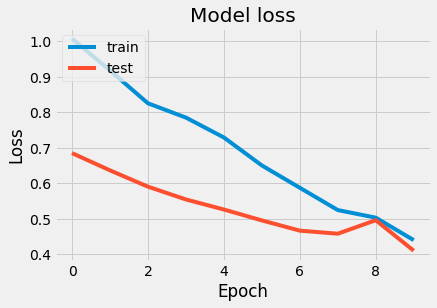

In [35]:
#可视化看下训练情况
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [36]:
"""模型评估"""
print('val AUC: %f' % model.evaluate(valx_model_input, valy, batch_size=batch_size)[1])
print('train AUC: %f' % model.evaluate(trnx_model_input, trny, batch_size=batch_size)[1])

20/20 [==============================] - 0s 3ms/sample - loss: 0.5565 - binary_crossentropy: 0.5565 - auc: 0.5781
val AUC: 0.556515
180/180 [==============================] - 0s 1ms/sample - loss: 0.4005 - binary_crossentropy: 0.4005 - auc: 0.8881
train AUC: 0.400468


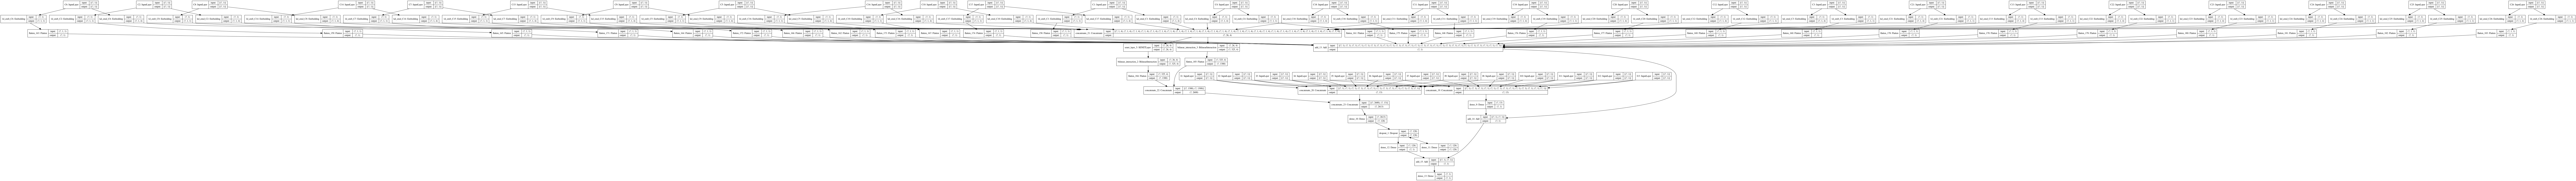

In [37]:
#模型架构
from tensorflow import keras
keras.utils.plot_model(model, to_file='./fibinet_arc.png', show_shapes=True)